In [1]:
import platform; print('python:',platform.python_version()); del platform # just for version
import numpy as np; print('numpy:',np.__version__); np.set_printoptions(precision=4,suppress=True)
import matplotlib as mpl; print('matplotlib:',mpl.__version__)
import matplotlib.pyplot as plt
plt.rc('axes',grid=True,axisbelow=True,facecolor='#EAEAF2',edgecolor='w'); plt.rc('grid',color='w'); plt.rc('legend',facecolor='w',edgecolor='w',framealpha=0)
%matplotlib inline
from scipy.linalg import solve_continuous_lyapunov
from time import time; ovt0 = time()

python: 3.8.11
numpy: 1.20.3
matplotlib: 3.4.2


In [2]:
# trick to make PDF outputs of figs acceptable for IEEE submission
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#### Plant system

$
\dot{x}_t
=
\begin{bmatrix}
0 & 1 \\
-a_1 & 2a_2
\end{bmatrix}
\begin{bmatrix}
x_{t,1}\\
x_{t,2}
\end{bmatrix}
+
\begin{bmatrix}
0\\
\beta
\end{bmatrix}
\big(u_t + \Theta^\top\Phi(x_t)\big) = A\,x_t + B\big(u_t + \Theta^\top\Phi(x_t)\big)
$

We use $a_1=2$, $a_2=0.5$, and $\beta=0.75$. This results an unstable, oscillatory $A$ matrix with $\text{eig}(A)= a_2 \pm \sqrt{a_2^2 - a_1} = 0.5 \pm j\sqrt{1.75\,}\,$, and reduced (75%) control input effectiveness.

The open-loop ($u_t=0$) plant system **without nonlinearity** is simulated below for initial conditions $x_0=[1\ 1]^\top$.

In [3]:
# timesteps
dt = 0.001 # time step size
t0 = 0. # initial sim time
tf = 10. # final sim time
ts = np.arange(t0,tf+dt,dt)
print('time steps:',ts,ts.shape)

time steps: [ 0.     0.001  0.002 ...  9.998  9.999 10.   ] (10001,)


A:
 [[ 0.  1.]
 [-2.  1.]] (2, 2)
eig: [0.5-1.3229j 0.5+1.3229j]
B:
 [[0.  ]
 [0.75]] (2, 1)
Euler integration simulation time: 0.0 sec



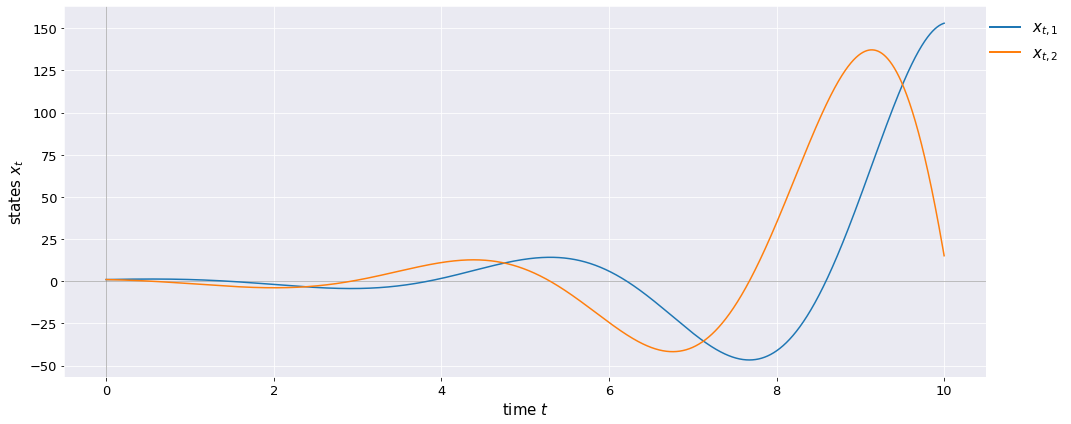

In [4]:
# plant
a1 = 2
a2 = 0.5
A = np.array([[0,1],
              [-a1,2*a2]])
A_eig = np.sort(np.linalg.eig(A)[0])

beta = 0.75
B = np.array([[0.],
              [beta]])

n = A.shape[0]
m = B.shape[1]

print('A:\n',A,A.shape)
print('eig:',A_eig)
print('B:\n',B,B.shape)

# state and initial condition
x = np.zeros((n,ts.size))
x[:,0] = [1.,1.]

tr0 = time()
for ti,t in enumerate(ts[:-1]):
    xDot = A@x[:,ti]
    x[:,ti+1] = x[:,ti] + xDot*dt

print('Euler integration simulation time: %.1f sec\n'%(time()-tr0))

plt.figure(figsize=(15,6))
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
for i in range(n): plt.plot(ts,x[i],label=r'$x_{t,%d}$'%(i+1))
leg = plt.legend(bbox_to_anchor=(0.99,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.xlabel(r'time $t$',fontsize=15)
plt.ylabel(r'states $x_t$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

#### Reference system

For any bounded reference input $r_t$, the desired state response is that of a damped harmonic oscillator system with unity gain:

$
\dot{x}_t^r
=
\begin{bmatrix}
0 & 1 \\
-\omega_0^2 & -2\xi\omega_0
\end{bmatrix}
\begin{bmatrix}
x_{t,1}^r \\
x_{t,2}^r
\end{bmatrix}
+
\begin{bmatrix}
0\\
\omega_0^2 
\end{bmatrix}
r_t
=
\begin{bmatrix}
0 & 1 \\
-2 & -2\sqrt{2}
\end{bmatrix}
x_t^r
+
\begin{bmatrix}
0\\
4
\end{bmatrix}
r_t
=
A_r \, x_t^r + B_r\ r_t
$

with the values $\omega_0=2$ and $\xi=1$, ensuring that $A_r$ is Hurwitz and nonoscillatory with $\text{eig}(A_r)=\left(-\xi \pm \sqrt{\xi^2 - 1\,}\,\right)\omega_0 = -2\,$.

The zero input ($r_t=0$) reference response is simulated below, from the same initial conditions as the plant above.

Ar:
 [[ 0  1]
 [-4 -4]] (2, 2)
eig: [-2.+0.j -2.-0.j]
Br:
 [[0.]
 [4.]] (2, 1)
Euler integration simulation time: 0.0 sec



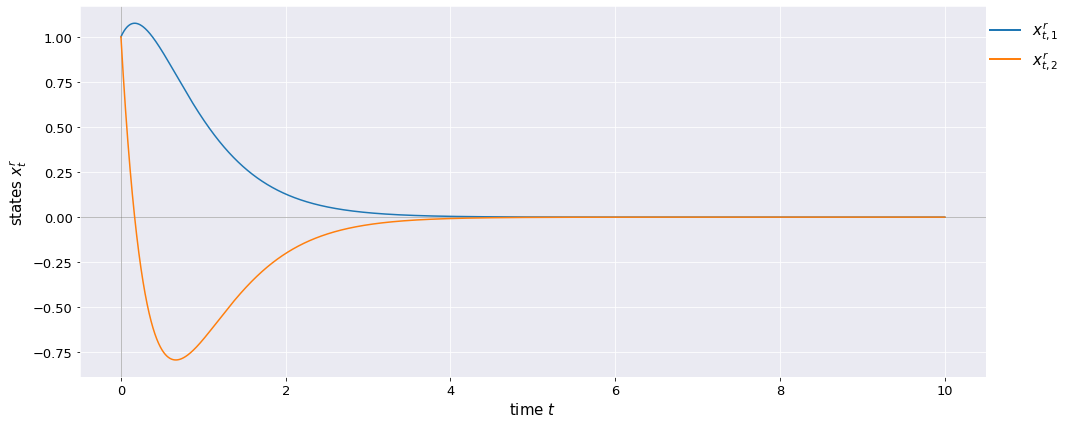

In [5]:
# reference
w0 = 2
xi = 1

Ar = np.array([[0,1],
               [-w0**2,-2*xi*w0]])
Ar_eig = np.linalg.eig(Ar)[0]
Br = np.array([[0.],
               [w0**2]])

print('Ar:\n',Ar,Ar.shape)
print('eig:',Ar_eig)
print('Br:\n',Br,Br.shape)

# state and initial condition
xr = np.zeros((n,ts.size))
xr[:,0] = x[:,0]

tr0 = time()
for ti,t in enumerate(ts[:-1]):
    xrDot = Ar@xr[:,ti]
    xr[:,ti+1] = xr[:,ti] + xrDot*dt

print('Euler integration simulation time: %.1f sec\n'%(time()-tr0))

plt.figure(figsize=(15,6))
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
for i in range(n): plt.plot(ts,xr[i],label=r'$x_{t,%d}^r$'%(i+1))
leg = plt.legend(bbox_to_anchor=(0.99,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.xlabel(r'time $t$',fontsize=15)
plt.ylabel(r'states $x_t^r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

#### Matching conditions and feedback gains


In order to achieve the reference state behavior from the linear part of the plant system (assuming the nonlinear part can be cancelled by the control input $u_t$),  
there must exist feedback gains $K^x=[k_1\ \ k_2]$ and $K^r=[l]$ satisfying the matching conditions:

$A + BK^x = A_r$\
$BK^r = B_r$

These conditions are satisfied with $k_1=-\frac{1}{\beta}(\omega_0^2-a_1)=-2.667$, $k_2=-\frac{1}{\beta}(2\xi\omega_0+2a_2)=-6.667$, and $l=\frac{\omega_0^2}{\beta}=5.333$.

In [6]:
Kx = -(1./beta) * np.array([[w0**2 - a1,
                          2*xi*w0 + 2*a2]])
Kr = np.array([[w0**2/beta]])

print('Kx:\n',Kx,Kx.shape)
print('Kr:\n',Kr,Kr.shape)

# confirm matching conditions
print(np.allclose(A + B @ Kx,Ar))
print(np.allclose(B @ Kr,Br))

Kx:
 [[-2.6667 -6.6667]] (1, 2)
Kr:
 [[5.3333]] (1, 1)
True
True


#### MRAC Control

We introduce parameter estimator states $\hat\Theta_t^\top = [\hat{\theta}_{1,t}\ \hat{\theta}_{2,t}\ \hat{\theta}_{3,t}\ \hat{\theta}_{4,t}]$ and define the MRAC control law:  
$u_t = K^x_t x_t + K^r_t r_t - \hat\Theta_t^\top\phi(x_t)\ $.

Applying this control input to the plant system results in dynamics for the state tracking error $e_t = x_t - x_t^r$ of:  
$\dot{e}_t = A_r\,e_t + B\,(\Theta-\hat\Theta_t)^\top\!\phi(x_t)\ $.

Lavretsky (section 9.5) proves that the state tracking error dynamics are globally uniformly asymptotically stable, such that $\lim_{t\to\infty}\|e_t\|=0$,  
if the estimator states are updated as:  
$\dot{\hat\Theta}_t = \Gamma\,\phi(x_t)\,e_t^\top PB \ ,$  
where $P$ is the unique solution to the algebraic Lyapunov equation $PA_r + {A_r}^\top P=Q$, for some symmetric, positive-definite matrix $Q$,  
and $\Gamma$ is an arbitrary symmetric, positive-definite matrix of adaption rate gains with bounded $\|\Gamma\|=r$.

For the simulation, we use
$Q =
\begin{bmatrix}
1 & 0 \\
0 & 10
\end{bmatrix}
$
and
$\Gamma =
\begin{bmatrix}
5 & 0 & 0 & 0 \\
0 & 1 & 0 & 0  \\
0 & 0 & 5 & 0 \\
0 & 0 & 0 & 2
\end{bmatrix}
$.

In [7]:
Q = np.diag([1,10])
P = solve_continuous_lyapunov(Ar.T,-Q) # note: transpose has to be used in this scipy function!
Gamma = np.diag([5,1,5,2])

print('Q:\n',Q,Q.shape)
print('sym:',np.allclose(Q,Q.T))
print('eig:',np.linalg.eig(Q)[0])
print('P:\n',P,P.shape)
print('sym:',np.allclose(P,P.T))
print('eig:',np.linalg.eig(P)[0])
print('Gamma:\n',Gamma,Gamma.shape)
print('sym:',np.allclose(Gamma,Gamma.T))
print('eig:',np.linalg.eig(Gamma)[0])

Q:
 [[ 1  0]
 [ 0 10]] (2, 2)
sym: True
eig: [ 1. 10.]
P:
 [[5.625  0.125 ]
 [0.125  1.2813]] (2, 2)
sym: True
eig: [5.6286 1.2777]
Gamma:
 [[5 0 0 0]
 [0 1 0 0]
 [0 0 5 0]
 [0 0 0 2]] (4, 4)
sym: True
eig: [5. 1. 5. 2.]


#### Linearly Parameterized Nonlinear Vector Function

The goal of this simulation is to demonstrate that if $\phi(x_t)$ is persistently exciting, then the parameter estimator states $\hat{\Theta}_t$ **will** converge to the true values of the parameters $\Theta$.

For the parameters, hyperplanes, and nonlinear vector function we use:  
$\Theta^\top = 
[\theta_1 \ \theta_2 \ \theta_3 \ \theta_4] = [-1.2\ \ 2.7\ \ 0.8\ -3.2]
\qquad
\phi(x_t) =
\begin{bmatrix}
\sigma_1\Big(W_1^\top x_t + b_1 \Big) \\
\sigma_2\Big(W_2^\top x_t + b_2 \Big) \\
\sigma_3\Big(W_3^\top x_t + b_3 \Big) \\
\sigma_4\Big(W_4^\top x_t + b_4 \Big) 
\end{bmatrix}
\qquad
W^\top = 
\begin{bmatrix}
2 & 1 \\
1 & -2 \\
1.5 & 0.5 \\
0.5 & 2
\end{bmatrix}
\quad
b = 
\begin{bmatrix}
1 \\
2 \\
2.5 \\
3
\end{bmatrix}
$

where $W_i^\top,b_i$ denotes the $i$th hyperplane and rows of $W^\top$ and $b$, and all $\sigma_i(x)=\text{max}(0,x)$ are the ReLU (ramp) function.  
$\phantom{a}$

The nonlinear vector function $\phi$, and thus the hyperplanes $W,b$, are known. The linear parameterization $\Theta$ is unknown.

In [8]:
Theta = np.array([[-1.2],
                   [2.7],
                   [0.8],
                   [-3.2]])
print('Theta^T:\n',Theta.T,Theta.T.shape)
N = Theta.shape[0]

def sigma(i,x): # ReLU (ramp)
    y = (WT[i] @ x + b[i])[0]
    return y * (y > 0)

# def sigma(i,x): # step
#     y = (WT[i] @ x + b[i])[0]
#     return 1. * (y > 0)

def phi(x):
    return np.array([sigma(i,x) for i in range(N)])

WT = np.array([[2.,1.],
               [1.,-2.],
               [1.5,-0.5],
               [0.5,2.]])
b = np.array([[1.],
              [2.],
              [2.5],
              [3.]])
print('W^T:\n',WT,WT.shape)
print('b:\n',b,b.shape)

Theta^T:
 [[-1.2  2.7  0.8 -3.2]] (1, 4)
W^T:
 [[ 2.   1. ]
 [ 1.  -2. ]
 [ 1.5 -0.5]
 [ 0.5  2. ]] (4, 2)
b:
 [[1. ]
 [2. ]
 [2.5]
 [3. ]] (4, 1)


#### Visualizing the hyperplanes and activation regions

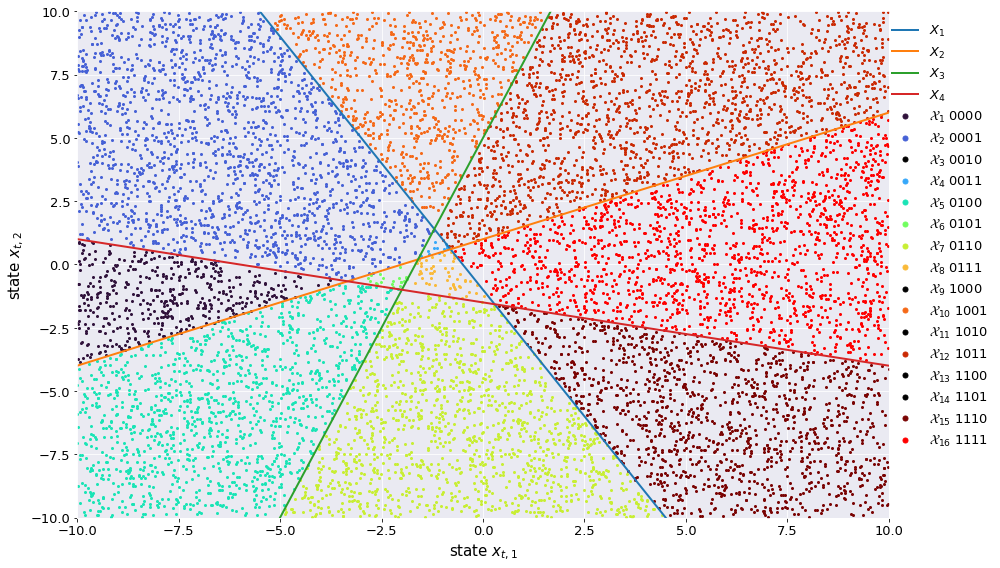

In [9]:
# each hyperplane is all points x in R^n that satisfy W_i^T x + b_i = 0
# so we'll just make two points (using the x range) and plot a line for each
xr = [-10,10]
hyps = []
for i in range(N):
    x1 = xr[0]
    y1 = (-b[i] - WT[i,0]*x1)/WT[i,1]  # x_2 = (-b_i - w_i,0*x_1)/w_i,1
    x2 = xr[1]
    y2 = (-b[i] - WT[i,0]*x2)/WT[i,1]
    hyps.append(((x1,x2),(y1,y2)))

# random points over the space to determine activation regions
Nrnd = 10000
np.random.seed(123)
Xrand = np.random.rand(n,Nrnd) # Nrnd points in R^n, each col is a point
Xrand[0] = (xr[1]-xr[0])*Xrand[0] + xr[0]
Xrand[1] = (xr[1]-xr[0])*Xrand[1] + xr[0]

Yrand = WT @ Xrand + b # value at each x point (cols) for each activation (rows)
Ybool = (Yrand > 0.) # turns Yrand into bool for if each element is > 0

# Yint: for each col of Ybool, maps the binary number to int of activation region
# eg: [True False True] = [1 0 1] --> 5
Yint = Ybool.T.dot(1 << np.arange(Ybool.shape[0] - 1, -1, -1))
Yintunq = np.unique(Yint) # list of activation regions

# plot the hyperplanes and activation regions
cmap = plt.cm.get_cmap('turbo',Yintunq.size-1)
regcol = 16*['k',]
for i in range(Yintunq.size-1): regcol[Yintunq[i]] = cmap(i)
regcol[-1] = 'r'
regbin = ["{0:04b}".format(i) for i in range(16)]

plt.figure(figsize=(14,8))
for i in range(Nrnd): plt.plot(Xrand[0,i],Xrand[1,i],c=regcol[Yint[i]],ls='None',marker='.',ms=4)
for i in range(N): plt.plot(hyps[i][0],hyps[i][1],lw=2,label=r'$X_{%d}$'%(i+1))
for i in range(16):
    plt.plot(np.inf,np.inf,c=regcol[i],ls='None',marker='.',ms=5,
             label=r'$\mathcal{X}_{%d}$ %s'%(i+1,regbin[i]))
plt.xlabel(r'state $x_{t,1}$',fontsize=15)
plt.ylabel(r'state $x_{t,2}$',fontsize=15)
plt.xlim(xr)
plt.ylim(xr)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
leg = plt.legend(bbox_to_anchor=(0.99,1),loc='upper left',fontsize=13, markerscale=2)
for hdl in leg.legendHandles: hdl.set_linewidth(2)
plt.tight_layout()
plt.show()

Each $\mathcal{X}$ is an activation region, and the binary string shows if component function $\sigma_1,\dots,\sigma_4$ of $\Phi$ are active or zero in that region.  
For example, $\mathcal{X}_6$ 0101 means that $\sigma_1$ is zero, $\sigma_2$ is active (positive), $\sigma_3$ is zero, and $\sigma_4$ is active in this region.

We can see from this graph that each activation $\sigma_i$ is **active** to the **right** of its hyperplane line $X_i$, and *zero* to the *left* of its hyperplane line.

#### Main Simulation

We will first use $r_t^{(1)} = 10\sin(0.5t)$ to drive the reference system into an elliptical limit cycle starting from the origin.  
The limit cycle will cross all hyperplanes at nondegenerate borders, thus meeting the requirements of the theory.

Therefore, we're guaranteed that the parameter estimates $\hat\Theta_t$ will converge to the true values $\Theta$ asymptotically.

In [10]:
# timesteps
dt = 0.001 # time step size
t0 = 0. # initial sim time
tf = 150. # final sim time
ts = np.arange(t0,tf+dt,dt)
print('time steps:',ts,ts.shape)

time steps: [  0.      0.001   0.002 ... 149.998 149.999 150.   ] (150001,)


In [11]:
r = 10*np.sin(0.5*ts)[np.newaxis,:] # make shape (1,ts.size)

u = np.zeros((m,ts.size))

x = np.zeros((n,ts.size))
xr = np.zeros((n,ts.size))

e = np.zeros((n,ts.size))
e[:,0] = x[:,0] - xr[:,0]

Thetahat = np.zeros((*Theta.shape,ts.size))

tr0 = time()
for ti,t in enumerate(ts[:-1]):

    u[:,ti] = Kx @ x[:,ti] + Kr @ r[:,ti] - Thetahat[...,ti].T @ phi(x[:,ti])

    xDot = A@x[:,ti] + B@(u[:,ti] + Theta.T @ phi(x[:,ti]))
    x[:,ti+1] = x[:,ti] + xDot*dt

    xrDot = Ar@xr[:,ti] + Br@r[:,ti]
    xr[:,ti+1] = xr[:,ti] + xrDot*dt

    e[:,ti+1] = x[:,ti+1] - xr[:,ti+1]
    eTPB = e[:,ti+1].T @ P @ B

    # update Thetahat to use for next timestep
    ThetahatDot = Gamma @ np.outer(phi(x[:,ti+1]),eTPB)
    Thetahat[...,ti+1] = Thetahat[...,ti] + ThetahatDot*dt

u[:,-1] = u[:,-2] # holdover for plot
print('Euler integration simulation time: %.1f sec'%(time()-tr0))

Euler integration simulation time: 10.9 sec


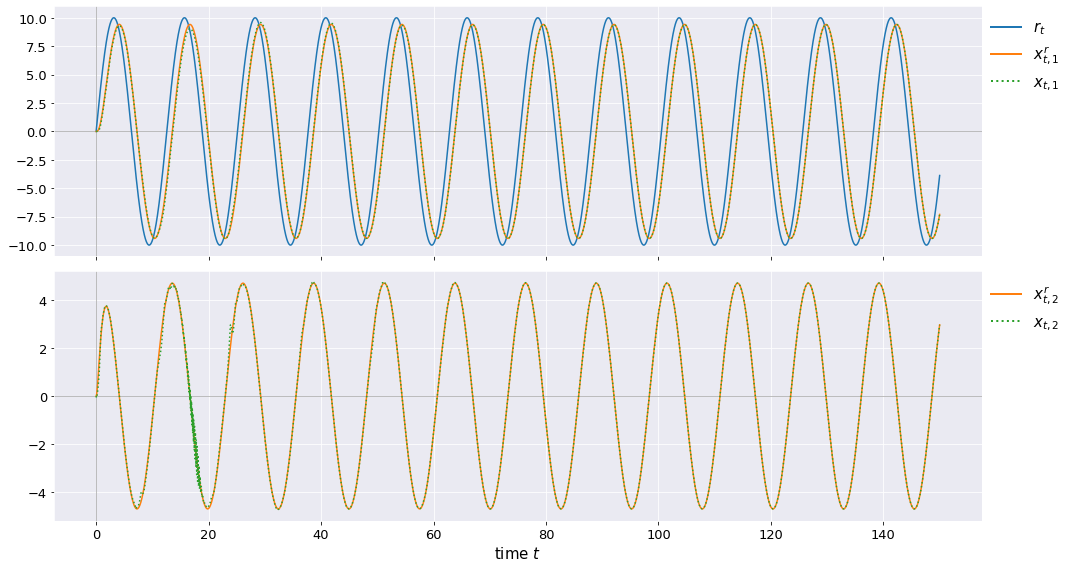

In [12]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(15,8))
plt.sca(ax[0])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,r[0],label=r'$r_t$')
plt.plot(ts,xr[0],label=r'$x_{t,1}^r$')
plt.plot(ts,x[0],ls=':',label=r'$x_{t,1}$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[1])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,xr[1],'C1',label=r'$x_{t,2}^r$')
plt.plot(ts,x[1],'C2',ls=':',label=r'$x_{t,2}$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.xlabel(r'time $t$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

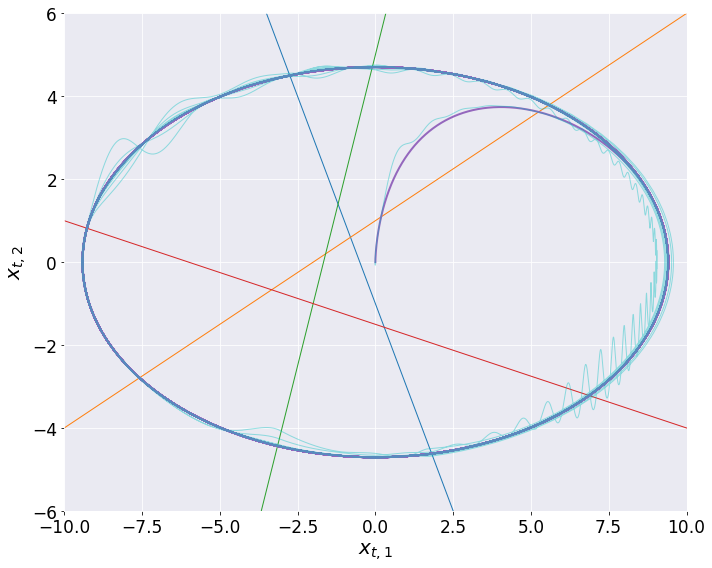

In [13]:
fig = plt.figure(figsize=(10,8))
# plt.axhline(0,c='gray',lw=0.5) # axes lines
# plt.axvline(0,c='gray',lw=0.5)
for i in range(N): plt.plot(hyps[i][0],hyps[i][1],lw=1)
plt.plot(xr[0],xr[1],lw=2)
plt.plot(x[0],x[1],c='c',ls='-',lw=1,alpha=0.4)
plt.xlabel(r'$x_{t,1}$',fontsize=20)
plt.ylabel(r'$x_{t,2}$',fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim([-10,10])
plt.ylim([-6,6])
plt.tight_layout()
plt.show()

fig.savefig('phase_plot.pdf',bbox_inches='tight',transparent=False)

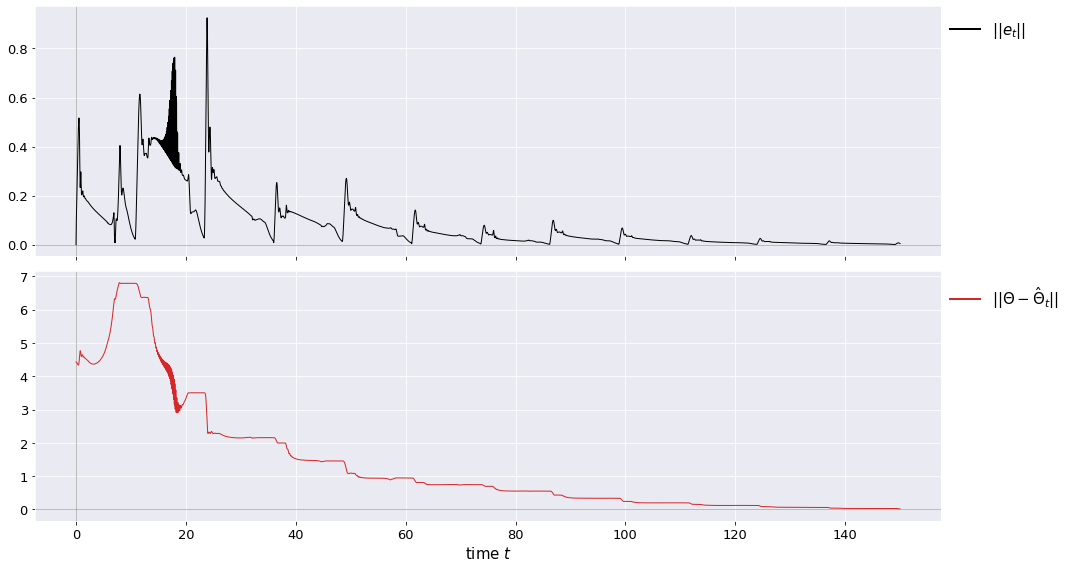

final timestep ||Theta-Thetahat|| (percentage relative to ||Theta||): 0.018


In [14]:
Thetats = np.tile(Theta,ts.size).reshape(Thetahat.shape)
ThetaErr = Thetats - Thetahat
ThErrNorm = np.linalg.norm(ThetaErr,axis=0).squeeze()

fig,ax = plt.subplots(2,1,sharex=True,figsize=(15,8))
plt.sca(ax[0])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,np.linalg.norm(e,axis=0),'k',label=r'$||e_t||$',lw=1)
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[1])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
# plt.plot(ts,u[0],'C3',label=r'$u_t$',lw=1)
plt.plot(ts,ThErrNorm,'C3',label=r'$||\Theta-\hat\Theta_t||$',lw=1)
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.xlabel(r'time $t$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

print('final timestep ||Theta-Thetahat|| (percentage relative to ||Theta||): %.3f'%(ThErrNorm[-1]))

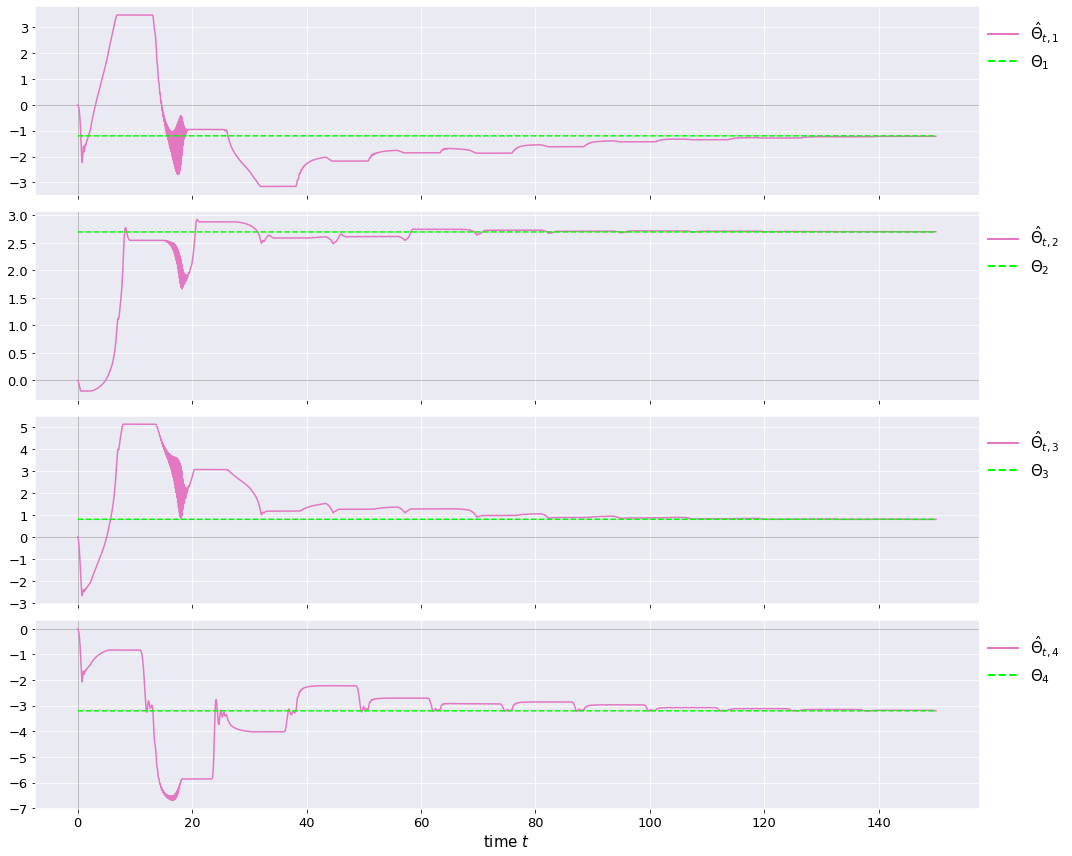

final timestep abs parameter estimation errors (percentage relative to |theta_i|):
theta 1 = -1.2  abs est error: 0.017  (1.42%)
theta 2 = 2.7  abs est error: 0.003  (0.13%)
theta 3 = 0.8  abs est error: 0.005  (0.57%)
theta 4 = -3.2  abs est error: 0.001  (0.02%)


In [15]:
fig,ax = plt.subplots(N,1,sharex=True,figsize=(15,12))
plt.sca(ax[0])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,Thetahat[0,0],'C6',label=r'$\hat{\Theta}_{t,1}$')
plt.plot(ts,np.full_like(ts,Theta[0]),c='lime',ls='--',label=r'$\Theta_1$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[1])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,Thetahat[1,0],'C6',label=r'$\hat{\Theta}_{t,2}$')
plt.plot(ts,np.full_like(ts,Theta[1]),c='lime',ls='--',label=r'$\Theta_2$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[2])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,Thetahat[2,0],'C6',label=r'$\hat{\Theta}_{t,3}$')
plt.plot(ts,np.full_like(ts,Theta[2]),c='lime',ls='--',label=r'$\Theta_3$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[3])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,Thetahat[3,0],'C6',label=r'$\hat{\Theta}_{t,4}$')
plt.plot(ts,np.full_like(ts,Theta[3]),c='lime',ls='--',label=r'$\Theta_4$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.xlabel(r'time $t$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

print('final timestep abs parameter estimation errors (percentage relative to |theta_i|):')
for i in range(N):
    thierr = abs(Theta[i]-Thetahat[i,0,-1])
    print('theta %d = %.1f  abs est error: %.3f  (%.2f%%)'%(i+1,Theta[i],thierr,(thierr/abs(Theta[i])*100)))

#### Sufficiently Rich Reference Input That Does Not Meet Requirements

This time, we will use $r_t^{(2)} = 40 + \sum_{i=1}^4 10\sin(0.25i\,t)$ to drive the reference system into a limit cycle starting from the origin.  
However, now the limit cycle **does not** cross all hyperplanes at nondegenerate borders.

Therefore, even though the reference input is "sufficiently rich" (contains a sufficient number of sinusoids with different frequencies) weare **not**  
guaranteed that the parameter estimates $\hat\Theta_t$ will converge to the true values $\Theta$ asymptotically.

In [16]:
r = 40 + 10*np.sin(0.25*ts)[np.newaxis,:] # make shape (1,ts.size)
r += 10*np.sin(0.5*ts)[np.newaxis,:]
r += 10*np.sin(0.75*ts)[np.newaxis,:]
r += 10*np.sin(1.*ts)[np.newaxis,:]

u = np.zeros((m,ts.size))

x = np.zeros((n,ts.size))
xr = np.zeros((n,ts.size))

e = np.zeros((n,ts.size))
e[:,0] = x[:,0] - xr[:,0]

Thetahat2 = np.zeros((*Theta.shape,ts.size))

tr0 = time()
for ti,t in enumerate(ts[:-1]):

    u[:,ti] = Kx @ x[:,ti] + Kr @ r[:,ti] - Thetahat2[...,ti].T @ phi(x[:,ti])

    xDot = A@x[:,ti] + B@(u[:,ti] + Theta.T @ phi(x[:,ti]))
    x[:,ti+1] = x[:,ti] + xDot*dt

    xrDot = Ar@xr[:,ti] + Br@r[:,ti]
    xr[:,ti+1] = xr[:,ti] + xrDot*dt

    e[:,ti+1] = x[:,ti+1] - xr[:,ti+1]
    eTPB = e[:,ti+1].T @ P @ B

    # update Thetahat to use for next timestep
    Thetahat2Dot = Gamma @ np.outer(phi(x[:,ti+1]),eTPB)
    Thetahat2[...,ti+1] = Thetahat2[...,ti] + Thetahat2Dot*dt

u[:,-1] = u[:,-2] # holdover for plot
print('Euler integration simulation time: %.1f sec'%(time()-tr0))

Euler integration simulation time: 11.0 sec


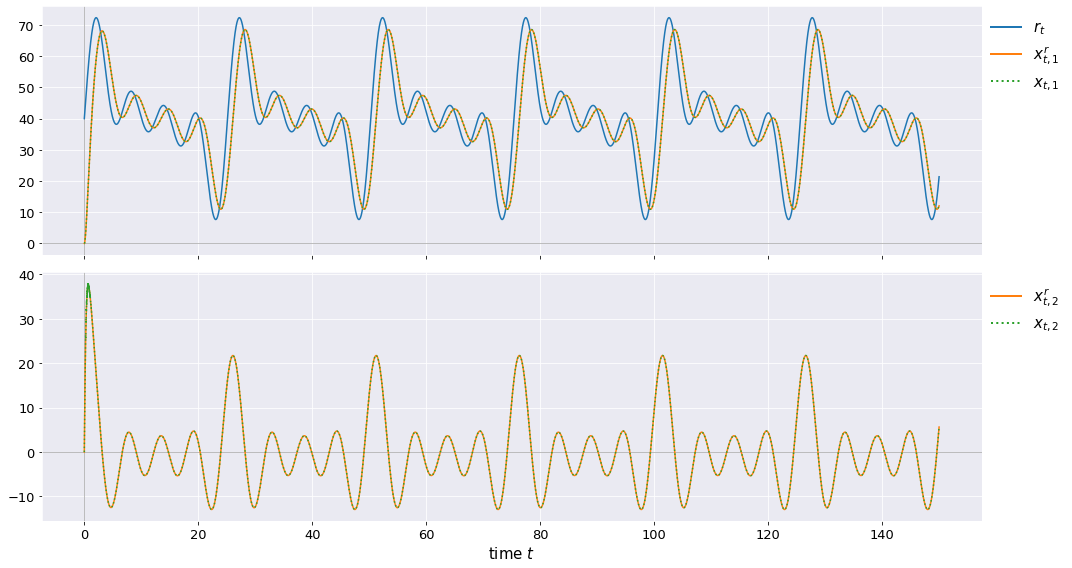

In [17]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(15,8))
plt.sca(ax[0])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,r[0],label=r'$r_t$')
plt.plot(ts,xr[0],label=r'$x_{t,1}^r$')
plt.plot(ts,x[0],ls=':',label=r'$x_{t,1}$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[1])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,xr[1],'C1',label=r'$x_{t,2}^r$')
plt.plot(ts,x[1],'C2',ls=':',label=r'$x_{t,2}$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.xlabel(r'time $t$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

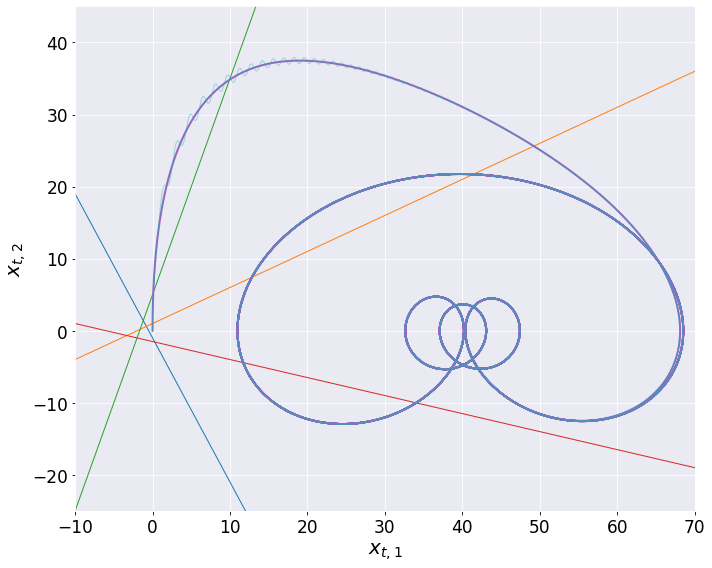

In [18]:
xrange = [-30,70]
hyps = []
for i in range(N):
    x1 = xrange[0]
    y1 = (-b[i] - WT[i,0]*x1)/WT[i,1]  # x_2 = (-b_i - w_i,0*x_1)/w_i,1
    x2 = xrange[1]
    y2 = (-b[i] - WT[i,0]*x2)/WT[i,1]
    hyps.append(((x1,x2),(y1,y2)))

fig = plt.figure(figsize=(10,8))
# plt.axhline(0,c='gray',lw=0.5) # axes lines
# plt.axvline(0,c='gray',lw=0.5)
for i in range(N): plt.plot(hyps[i][0],hyps[i][1],lw=1)
plt.plot(xr[0],xr[1],lw=2)
plt.plot(x[0],x[1],c='c',ls='-',lw=1,alpha=0.4)
plt.xlabel(r'$x_{t,1}$',fontsize=20)
plt.ylabel(r'$x_{t,2}$',fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim([-10,70])
plt.ylim([-25,45])
plt.tight_layout()
plt.show()

fig.savefig('phase_plot2.pdf',bbox_inches='tight',transparent=False)

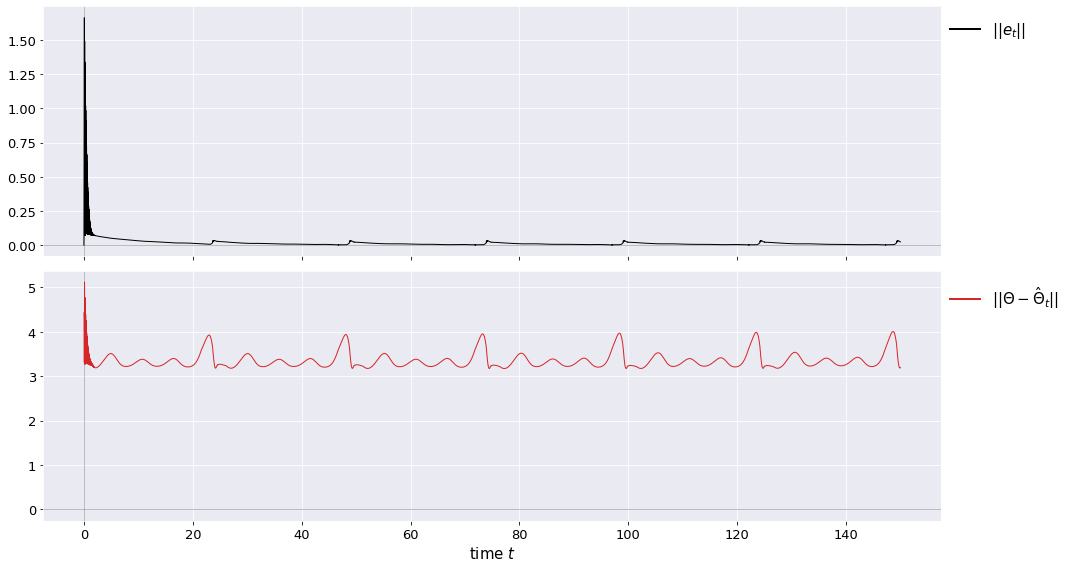

final timestep ||Theta-Thetahat|| (percentage relative to ||Theta||): 3.195


In [19]:
Thetats = np.tile(Theta,ts.size).reshape(Thetahat.shape)
ThetaErr2 = Thetats - Thetahat2
ThErr2Norm = np.linalg.norm(ThetaErr2,axis=0).squeeze()

fig,ax = plt.subplots(2,1,sharex=True,figsize=(15,8))
plt.sca(ax[0])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,np.linalg.norm(e,axis=0),'k',label=r'$||e_t||$',lw=1)
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[1])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
# plt.plot(ts,u[0],'C3',label=r'$u_t$',lw=1)
plt.plot(ts,ThErr2Norm,'C3',label=r'$||\Theta-\hat\Theta_t||$',lw=1)
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.xlabel(r'time $t$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

print('final timestep ||Theta-Thetahat|| (percentage relative to ||Theta||): %.3f'%(ThErr2Norm[-1]))

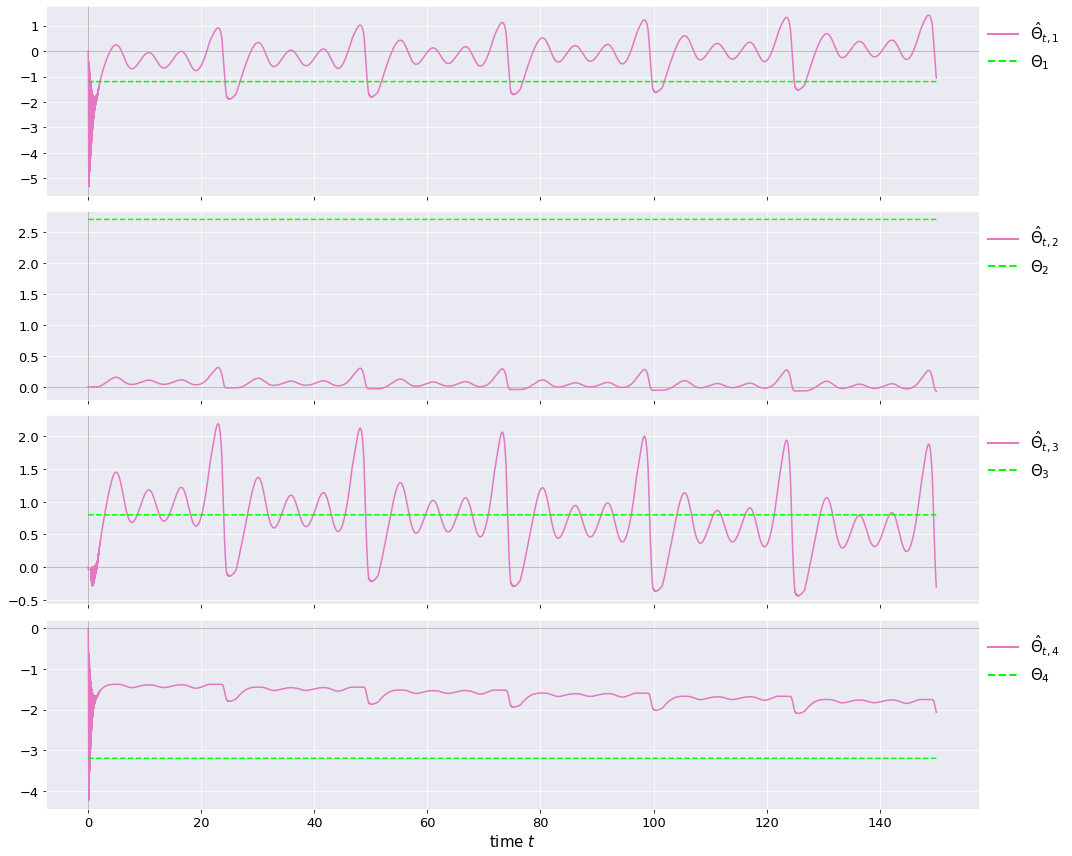

final timestep abs parameter estimation errors (percentage relative to |theta_i|):
theta 1 = -1.2  abs est error: 0.017  (1.42%)
theta 2 = 2.7  abs est error: 0.003  (0.13%)
theta 3 = 0.8  abs est error: 0.005  (0.57%)
theta 4 = -3.2  abs est error: 0.001  (0.02%)


In [20]:
fig,ax = plt.subplots(N,1,sharex=True,figsize=(15,12))
plt.sca(ax[0])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,Thetahat2[0,0],'C6',label=r'$\hat{\Theta}_{t,1}$')
plt.plot(ts,np.full_like(ts,Theta[0]),c='lime',ls='--',label=r'$\Theta_1$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[1])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,Thetahat2[1,0],'C6',label=r'$\hat{\Theta}_{t,2}$')
plt.plot(ts,np.full_like(ts,Theta[1]),c='lime',ls='--',label=r'$\Theta_2$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[2])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,Thetahat2[2,0],'C6',label=r'$\hat{\Theta}_{t,3}$')
plt.plot(ts,np.full_like(ts,Theta[2]),c='lime',ls='--',label=r'$\Theta_3$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.yticks(fontsize=13)
plt.sca(ax[3])
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,Thetahat2[3,0],'C6',label=r'$\hat{\Theta}_{t,4}$')
plt.plot(ts,np.full_like(ts,Theta[3]),c='lime',ls='--',label=r'$\Theta_4$')
leg = plt.legend(bbox_to_anchor=(0.995,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.xlabel(r'time $t$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

print('final timestep abs parameter estimation errors (percentage relative to |theta_i|):')
for i in range(N):
    thierr = abs(Theta[i]-Thetahat[i,0,-1])
    print('theta %d = %.1f  abs est error: %.3f  (%.2f%%)'%(i+1,Theta[i],thierr,(thierr/abs(Theta[i])*100)))

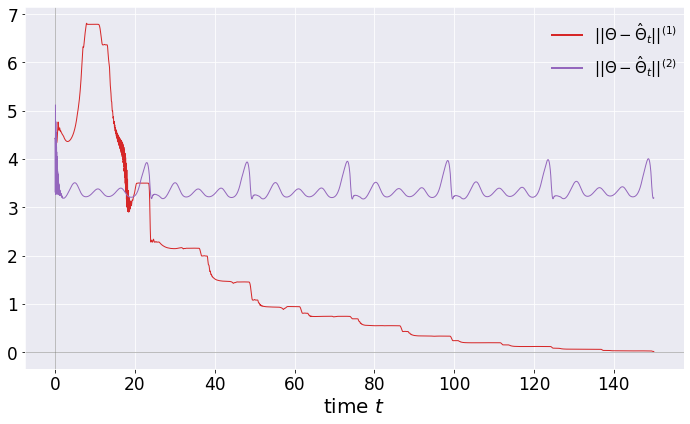

In [21]:
# combined plot for paper

fig = plt.figure(figsize=(10,6))
plt.axhline(0,c='gray',lw=0.5) # axes lines
plt.axvline(0,c='gray',lw=0.5)
plt.plot(ts,ThErrNorm,'C3',label=r'$||\Theta-\hat\Theta_t||^{(1)}$',lw=1)
plt.plot(ts,ThErr2Norm,'C4',label=r'$||\Theta-\hat\Theta_t||^{(2)}$',lw=1)
leg = plt.legend(bbox_to_anchor=(0.78,1),loc='upper left',fontsize=15)
for line in leg.legendHandles: line.set_linewidth(2)
plt.xlabel(r'time $t$',fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.show()

fig.savefig('theta_est_conv.pdf',bbox_inches='tight',transparent=False)